# Test theory about number of recombination events
Simulate data, compare it to theory

## Problem: Selfing implies that neighboring recombination events are not completely independent anymore: I.e. recombination rates depend on the overall history of the block.
For instance, by chance highly selfing lineages can be a problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
def create_recs(l):
    """l: Length of Chromosome [in Morgan]
    Do recombination events for length l"""
    # Draw Number of Recombination events:
    k = np.random.poisson(lam=l)

    # Do their Distribution
    recs = l * np.random.random(size=k)
    return recs

def sim_recomb(l, s, t):
    """
    l: Length of the Chromosome [in Morgan]
    s: Selfing Rate: 0-1.
    t: Time [in Generations]
    Simulate Recombination events. Return sorted list of the effective recombination events"""
    t=t+1
    ocs = (np.random.random(size=t) > s)   # Pick up where outcrossing events occur.
    
    final_recs = np.array([], dtype = np.float)       # Final Recombination Events. Initialize empty.
    recs = np.array([], dtype = np.float)  # Current Recombination Events. Initialize empty.
    
    # Run through time, swithch if outcrossing or inbreeding
    for i in range(t):
        # Heal Recombination Events
        if ocs[i] == False:   # In case of selfing
            k = len(recs)
            healing = (np.random.random(size=k)>0.5)   # Draw where not healed.
            recs = recs[healing] # Heal where needed.
            
            # Do the new Recombination:
            new_recs = create_recs(l)
            recs = np.concatenate((recs, new_recs))
            
        # Create them
        else:
            # In Case of outcrossing:
            final_recs = np.concatenate((final_recs, recs)) # Appends the Final Recombination Events 
            recs = create_recs(l)   # Create the new recombination events!
            
    #final_recs = np.concatenate((final_recs, recs))
    final_recs = np.concatenate(([0], final_recs, [l]))
    final_recs = np.sort(final_recs)   # Do the final Sorting
    return final_recs

###########################################################
###########################################################

def post_process_recomb_list(rec_list, bins):
    """Return Nr or blocks in the bins.
    
    rec_list: array-like, sorted list of recombination events
    bins: array-like, sorted list of bins
    Everything measured in Morgan!"""
    bl_lengths = rec_list[1:] - rec_list[:-1]  # Calculate the Block Lengths
    
    # Sort the blocks into the bins:
    counts, _ = np.histogram(bl_lengths, bins=bins)
    return counts


def replicate_statistics(l, s, t, nr_reps, bins, nr_cores=0):
    """Run many replicates of Recombinations along a lineage.
    Return average count in bins
    nr_reps: How many replicates to run.
    bins: Array of floats. Which bins delitations to use.
    l: Length of the Chromosome [in Morgan]
    s: Selfing Rate: 0-1.
    t: Time [in Generations]
    nr_cores: For replication (IMPLEMENT LATER IF NEEDED.)
    """
    counts = np.zeros(len(bins)-1, dtype = "int")
    
    for _ in range(nr_reps):
        rec_list = sim_recomb(l, s, t)
        #rec_list = np.concatenate(())
        counts += post_process_recomb_list(rec_list, bins)
        
    return counts/nr_reps

###########################################################
###########################################################
# Do the theory predictions

def blocks_predicted(func, bins, t, s, chr_len=1, boundary=False):
    """Give the Nr of predicted Blocks.
    func: The used function - pointer to the function
    chr_length: Length of the whole chromosome in Morgan"""
    
    mid_bins = (bins[1:] + bins[:-1]) / 2.0
    bin_widths = (bins[1:] - bins[:-1])
    
    exp_shr = func(mid_bins, t, s, chr_len, boundary=boundary) * bin_widths # Do the actual calculation

    return exp_shr

#####################################
#####################################
# The corrected Functions:

def func_classic(l, t, s=0, chr_len=1, boundary=True):
    """Classical Function of block sharing. If l vec, return vec"""
    x = np.exp(-l * t) * t**2 * (chr_len - l)  # Probability of no recomb times start/end
    
    if boundary == True:
        x += 2 * np.exp(-l * t) * t # Starting at two edges 
    return x
    
def func_selfing_corr_simple(l, t, s=0, chr_len=1, boundary=True):
    """Function for block sharing with the simple correction factor."""
    corr_factor = (2 - 2 * s) / (2 - s) # Calculate the correction factor
    eff_chr = chr_len * corr_factor # Rescale Chromosome Length
    eff_l = l * corr_factor         # Rescale the Block length
    
    x = func_classic(eff_l, t, s=0, chr_len = eff_chr, boundary=boundary)
        
    return x * corr_factor # The last factor is for the fact the bin width is reduced as well
    
def func_selfing_corr_poisson(l, t, s=0, chr_len=1, boundary=False):
    """Function of block sharing with the complex correlations of selfing.
    Assume Nr of outcrossing events is poisson distributed, and every outcrossing
    induces rec. at rate 2 (1 from prev. gen, 0.5 from before; and so forth
    boundary: Whether to use Boundary effects. False: No"""
    lam = (1-s) * t 
    
    bas = np.exp(-lam * (1 - np.exp(-2* l)))
    a = (lam**2 * np.exp(-4 * l) * 4)
    b = (lam * np.exp(-2*l) * 4)
    
    
    prod = bas * (a + b) * (chr_len - l)
    if boundary == True:
        prod += bas * b
    return prod

In [5]:
# Test the function
a = sim_recomb(10.0, s=0.0, t=10000)
len(a)  # Print how many effective recombination events

### Test how man recomb events are healed:
ss=0.5
b = sim_recomb(10.0, s=ss, t=10000)

print("Effective Frac: Estimated: %.6f" % (len(b)/ len(a)))
print("Effective Frac: Theory: %.6f" % ((2 - 2 * ss) / (2 - ss)))

Effective Frac: Estimated: 0.660310
Effective Frac: Theory: 0.666667


# Test theory on replicate runs:

In [53]:
### Create the data: Run nr of replicated
bins=np.linspace(0.05,1.05,51)
s = 0.5
chr_len = 2
t=20

bon = True

# Run the simulations
counts = replicate_statistics(l=chr_len, s=s, t=t, nr_reps=10000, bins=bins, nr_cores=0)
print("Simulations complete!")


pred_classic = blocks_predicted(func_classic, bins, t=t, s=s, chr_len=chr_len)
print("Theory predictions classic: Done")

pred_simple_self = blocks_predicted(func_selfing_corr_simple, bins, t=t, s=s, chr_len=chr_len)
print("Theory predictions simple selfing: Done")

pred_compl_corr = blocks_predicted(func_selfing_corr_poisson, bins, t=t, s=s, chr_len=chr_len, boundary=bon)
print("Theory predictions Poisson selfing: Done")

Simulations complete!
Theory predictions classic: Done
Theory predictions simple selfing: Done
Theory predictions Poisson selfing: Done


In [43]:
pred_simple_self

array([0.35296392, 0.32679609, 0.30253544, 0.28004482, 0.25919682,
       0.23987312, 0.22196382, 0.20536685, 0.18998743, 0.17573755,
       0.16253548, 0.15030534, 0.13897668, 0.12848408, 0.11876683,
       0.10976856, 0.10143694, 0.09372343, 0.08658293, 0.07997364,
       0.07385672, 0.06819616, 0.06295853, 0.05811284, 0.05363031,
       0.04948424, 0.0456499 , 0.04210431, 0.03882618, 0.03579575,
       0.03299472, 0.03040609, 0.02801412, 0.02580422, 0.02376284,
       0.02187744, 0.02013639, 0.01852892, 0.01704504, 0.01567548,
       0.01441169, 0.0132457 , 0.01217017, 0.01117828, 0.0102637 ,
       0.0094206 , 0.00864355, 0.00792755, 0.00726796, 0.00666046])

## Do the plotting:

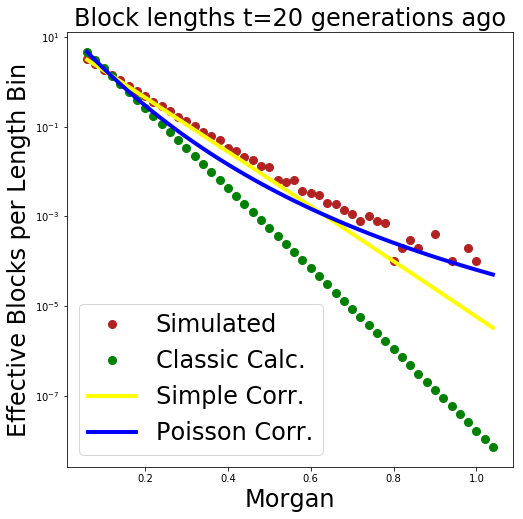

In [54]:
fs = 24
mid_bins = (bins[1:] + bins[:-1]) / 2.0


plt.figure(figsize=(8, 8))
plt.plot(mid_bins, counts, linestyle="", marker = "o", label ="Simulated", markersize=8, color = "firebrick")
plt.plot(mid_bins, pred_classic, linestyle="",  marker = "o", label ="Classic Calc.", markersize=8, color = "green" )
plt.plot(mid_bins, pred_simple_self, label ="Simple Corr.", markersize=8, color = "yellow", linewidth=4)
plt.plot(mid_bins, pred_compl_corr, label ="Poisson Corr.", markersize=8, color = "blue", linewidth=4)


plt.xlabel("Morgan", fontsize = fs)
plt.ylabel("Effective Blocks per Length Bin", fontsize = fs)
plt.legend(fontsize = fs)
plt.yscale("log")
plt.title("Block lengths t=%i generations ago" % t, fontsize=fs)

save_name = "Figures/formular_mismatch_gen=" + str(t) + ".pdf" 
#plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
plt.show()

## Do the same for a 4x4 Plot!

In [79]:
### Create the data: Run nr of replicated
bins=np.linspace(0.05,1.05, 41)
s = 0.9
chr_len = 2
t_vec = [5, 20, 40, 80]

bon = True # Whether do do the Boundary Conditions

counts = np.zeros((len(t_vec), len(bins)-1))
pred_fis = np.zeros((len(t_vec), len(bins)-1))
pred_compl_corr = np.zeros((len(t_vec), len(bins)-1))

for i, t in enumerate(t_vec):
    # Run the simulations
    print("Doing time: %i" %t)
    counts[i,:] = replicate_statistics(l=chr_len, s=s, t=t, nr_reps=10000, bins=bins, nr_cores=0)
    print("Simulations complete!")
    pred_fis[i,:] = blocks_predicted(func_selfing_corr_simple, bins, t=t, s=s, chr_len=chr_len, boundary=bon)
    print("Theory predictions simple selfing: Done")

    pred_compl_corr[i,:] = blocks_predicted(func_selfing_corr_poisson, bins, t=t, s=s, chr_len=chr_len, boundary=bon)
    print("Theory predictions Poisson selfing: Done")
print("All: Done")

Doing time: 5
Simulations complete!
Theory predictions simple selfing: Done
Theory predictions Poisson selfing: Done
Doing time: 20
Simulations complete!
Theory predictions simple selfing: Done
Theory predictions Poisson selfing: Done
Doing time: 40
Simulations complete!
Theory predictions simple selfing: Done
Theory predictions Poisson selfing: Done
Doing time: 80
Simulations complete!
Theory predictions simple selfing: Done
Theory predictions Poisson selfing: Done
All: Done


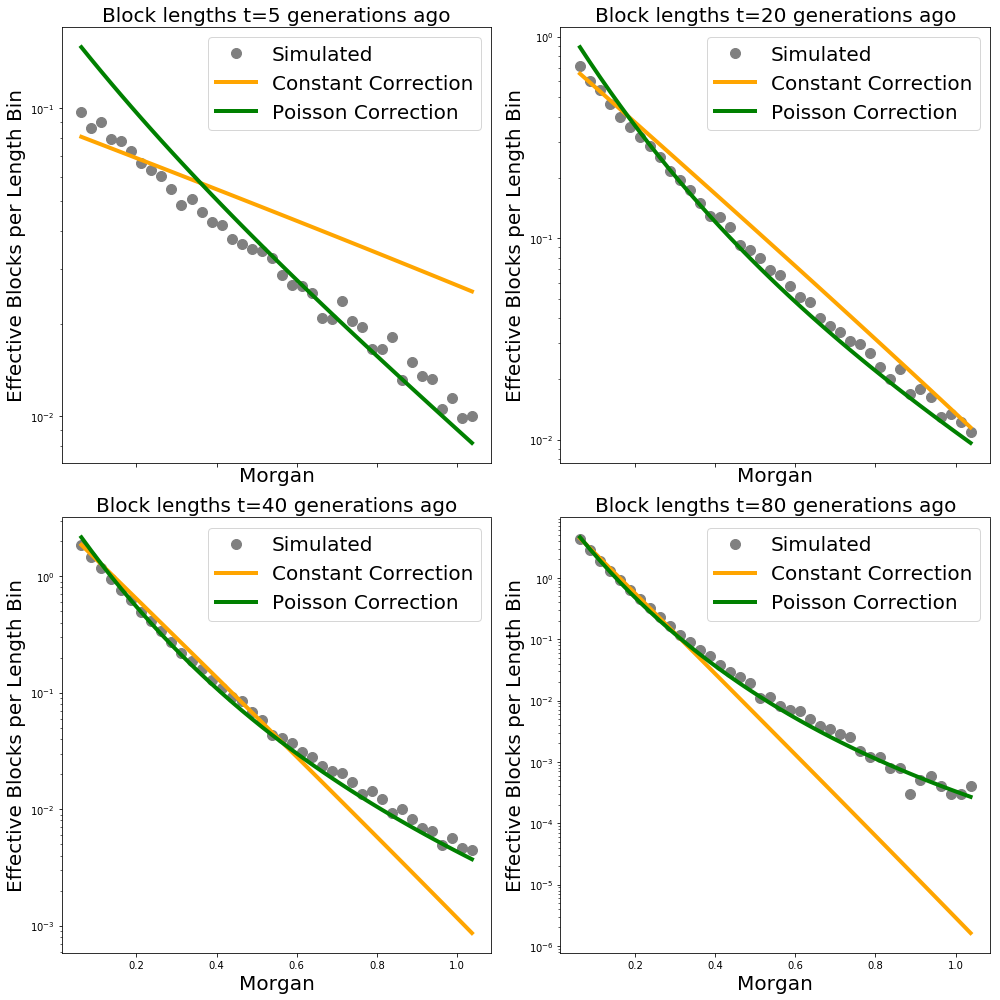

In [80]:
fs = 20
mid_bins = (bins[1:] + bins[:-1]) / 2.0

f, axarr = plt.subplots(2, 2, sharex=True, figsize=(14,14))

for i,p in enumerate(axarr.flatten()):
    p.plot(mid_bins, counts[i,:], linestyle="", marker = "o", label ="Simulated", markersize=10, color = "gray")
    #plt.plot(mid_bins, pred_classic, linestyle="",  marker = "o", label ="Classic Calc.", markersize=8, color = "green" )
    p.plot(mid_bins, pred_fis[i,:], label ="Constant Correction", markersize=8, color = "orange", linewidth=4)
    p.plot(mid_bins, pred_compl_corr[i,:], label ="Poisson Correction", markersize=8, color = "green", linewidth=4)


    p.set_xlabel("Morgan", fontsize = fs)
    p.set_ylabel("Effective Blocks per Length Bin", fontsize = fs)
    p.legend(fontsize = fs)
    p.set_yscale("log")
    p.set_title("Block lengths t=%i generations ago" % t_vec[i], fontsize=fs)
plt.tight_layout()
save_name = "Figures/block_lengths_selfing_4_s=0.5.pdf" 
#plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
plt.show()

# Test effective Nr of recombination events:

# Area 51: For trying the crazy stuff!

In [14]:
rec_list = np.array([0.1, 0.3, 0.7, 0.73, 0.8, 0.81])
bins = np.linspace(0,1,21)
post_process_recomb_list(rec_list, bins)

array([2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

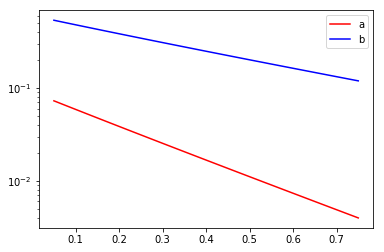

In [146]:
# Test the relative contribution:
t=3
s=0.95

l = np.linspace(0.05,0.75,100)
lam = lam = (1-s) * t 

a = np.exp(-lam * (1 - np.exp(-2* l))) * (lam**2 * np.exp(-4 * l) * 4)
b = np.exp(-lam * (1 - np.exp(-2* l))) * (lam * np.exp(-2*l) * 4)

plt.figure()
plt.plot(l,a, c="r", label="a")
plt.plot(l,b, c="b", label="b")
plt.legend()
plt.yscale("log")
plt.show()